In [5]:
import gwsurrogate
import numpy as np
import matplotlib.pyplot as plt
import bilby
from gwpy.timeseries import TimeSeries

In [6]:
sur=gwsurrogate.LoadSurrogate('NRSur7dq4')

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/gwsurrogate/new/precessing_surrogate.py:245: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.t = h5file['t_ds'].value
/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/gwsurrogate/new/precessing_surrogate.py:272: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'coefs': group['%s_coefs'%(key)].value,
/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/gwsurrogate/new/precessing_surrogate.py:273: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'bfOrders': group['%s_bfOrders'%(key)].value
/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/gwsurrogate/new/precessing_surrogate.py:282: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'coefs': group['%s_%d_coefs'%(key, i)].value,
/Users/zohaggard/anaconda2/envs/igw

Loaded NRSur7dq4 model


In [63]:
def sigmoid(time, x0, L, k):
    
    """ generate a sigmoid to be mult. to damped sinusoid.
        x is time, x0 is the midpoint of the sigmoid, L is the amplitude, and k is the growth 
    """
    
    sig = []
    
    for item in time:
        value=L/(1+np.exp(-k*(item-x0)))
        sig.append(value)
        
    return sig

In [13]:
def create_bru_values(m_odd, em, M, a, n_ref):
    
    """ 
    m_odd is odd integer, n_ref is the refractive index, which is 1/g_s (string coupling, (GR == 0)), em is 2,
    M is total mass, a is dimensionless spin, and amplitude_qnm is 
    the amplitude of the mode of interest 
    
    returns amplitude (quantum), omega_real, tau, and tp
    
    """
    
    g_s = 1/n_ref
    c = 3e8
    G = 6.67e-11
    Msun = 1.989e30
    
    conversion_w = (c**3)/(G * M * Msun)
    R_con = (2 * G * M * Msun) / (c**2)
    
    r_s = (R_con + np.sqrt((R_con**2) - 4*(a**2)))/2 #units m
    omega_real = (m_odd * np.pi /(2 * r_s * n_ref)) * c   #units 1/m --> 1/s
    omega_im = - (1/r_s) * (1/(n_ref**2)) * c
    
    tau = 1/omega_im
    tp = 1/omega_real 
    
    print("Quantum freq is {}".format(omega_real/(2*np.pi)))
    print("Quantum tau is {}".format(tau))
    print("t_s is {}".format(tp))
    
    return {'omega_real': omega_real, 'omega_img_Q': omega_im,
            'tau': tau, 'tp': tp, 'freq': (omega_real/(2*np.pi)), 'phase':0}

In [47]:
def bru_sine(time, amplitude, tau, tp, omega_real, phase, **kwargs):
    
    """
    returns damped complex sine as h (type=array) 
    assumes that tau is negative number

    """
    
    
    h = np.zeros(len(time), dtype=np.complex128)
    tidx = time >= tp
    
    damp_arg = (time[tidx])/tau
    sin_arg = (omega_real * (time[tidx])) - phase
    h[tidx] = amplitude*np.exp(damp_arg) * np.exp((1j*sin_arg)) 
   
    return h

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


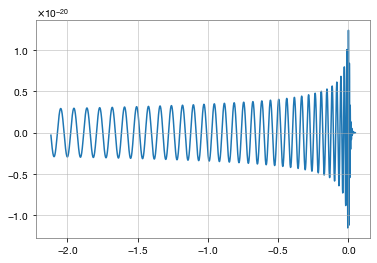

In [53]:
q = 1
chiA = [0,0,0]
chiB = [0,0,0]
M = 100
dist_mpc = 100
ellMax = 4     
inclination = 0
f_low=0
f_ref = 30
dt=1/4096

t, h, dyn = sur(q, chiA, chiB, dt=dt, f_low=f_low, ellMax=ellMax, M=M, dist_mpc=dist_mpc,
               inclination=inclination, units='mks', f_ref=f_ref)
plt.plot(t, h)

In [131]:
quantum=bru_sine(t, amplitude=6e-19, omega_real=2*np.pi*84.7992293, tau=-0.00884442, phase=0, tp=0.001876844)

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0, 0.05)

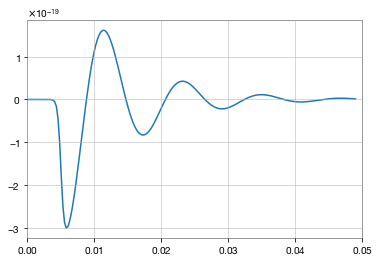

In [132]:
sigtp=sigmoid(t, x0=0.005, L=6e-21, k=4096)
taper=quantum*sigtp/6e-21

plt.plot(t, taper)
plt.xlim(0,0.05)

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0, 0.02)

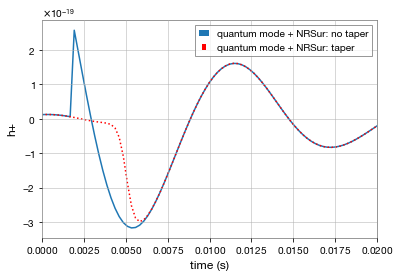

In [133]:
plt.plot(t, quantum+h,label='quantum mode + NRSur: no taper')
plt.plot(t, taper+h, label='quantum mode + NRSur: taper',linestyle=':', color='red')
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('h+')
plt.xlim(0,0.02)

In [157]:
hdata_taper = TimeSeries(taper+h, times=t)
hqt = hdata_notaper.q_transform(whiten=False, outseg=(-0.001,0.02))
hqt=np.abs(hqt)
hqt.max()

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/numpy/fft/fftpack.py:387: ComplexWarning: Casting complex values to real discards the imaginary part
  a = array(a, copy=True, dtype=float)


<Quantity 6.840913e+16>

In [158]:
hdata_notaper = TimeSeries(quantum+h, times=t)
hqnt = hdata_notaper.q_transform(whiten=False, outseg=(-0.001,0.02))
hqnt=np.abs(hqnt)
hqnt.max()

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/numpy/fft/fftpack.py:387: ComplexWarning: Casting complex values to real discards the imaginary part
  a = array(a, copy=True, dtype=float)


<Quantity 6.840913e+16>

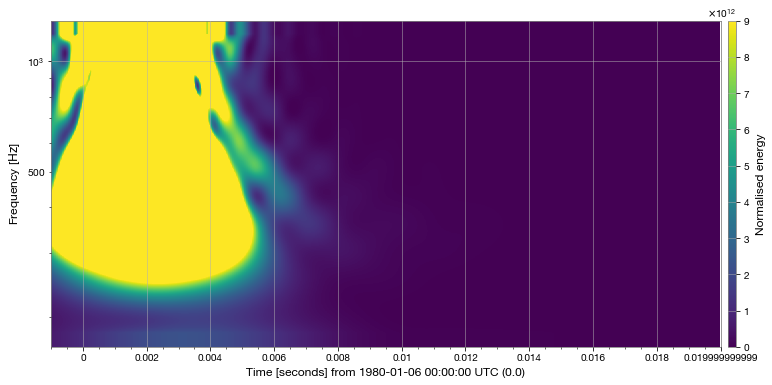

In [159]:
plot = hqnt.plot()
plot.colorbar(label="Normalised energy", vmin=1e1, vmax=9e12)
ax = plot.gca()
ax.set_yscale('log')

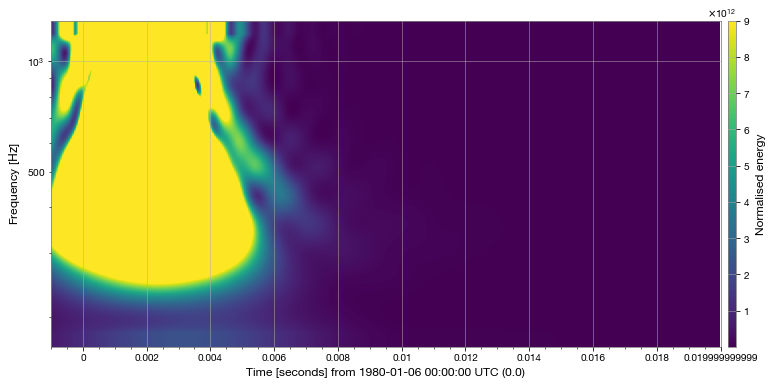

In [160]:
plot = hqt.plot()
plot.colorbar(label="Normalised energy", vmin=1e3, vmax=9e12)
ax = plot.gca()
ax.set_yscale('log')